Importing packages

In [1]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

## Implementing the Kalman filtering technique 

In [2]:
# Predict step
def predict(x, P, F, Q):
    x = np.dot(F, x)  # State prediction
    P = np.dot(F, np.dot(P, F.T)) + Q  # Covariance prediction
    return x, P

In [3]:
# Update step
def update(x, P, Z, H, R):
    y = Z - np.dot(H, x)  # Measurement residual
    S = np.dot(H, np.dot(P, H.T)) + R  # Residual covariance
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))  # Kalman gain
    x = x + np.dot(K, y)  # State update
    P = P - np.dot(K, np.dot(H, P))  # Covariance update
    return x, P

In [4]:
# Necessary functions
def kalman_filter(data, initial_price, P, F, H, Q, R):
    n = len(data)
    estimates = np.zeros(n)
    
    x = np.array([[initial_price]])  # Initialize state vector
    
    for i in range(n):
        if np.isnan(data[i]):
            # Predict if the data point is missing
            x, P = predict(x, P, F, Q)
        else:
            # Update if the data point is available
            Z = np.array([[data[i]]])
            x, P = update(x, P, Z, H, R)
        
        estimates[i] = x[0][0]
        
    return estimates

In [5]:
# Import dataset
df = pd.read_csv("../apple_2023_masked.csv")
data = df["5day"].copy()
data

0      124.048042
1      125.327515
2      123.998451
3      128.560867
4      129.086517
          ...    
245    193.091385
246    192.542816
247    192.642548
248    193.071426
249    192.024185
Name: 5day, Length: 250, dtype: float64

<Axes: >

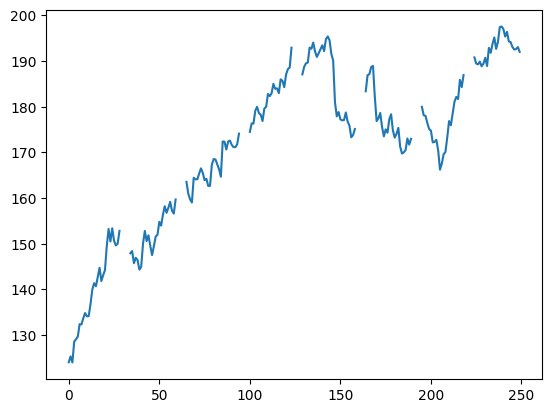

In [16]:
data.plot()

In [7]:
# filter parameters initialization
initial_price = data[0]  # initial state

P = np.array([[1]])  # covariance matrix
F = np.array([[1]])  # state transition matrix
H = np.array([[1]])  # observation matrix
Q = np.array([[0.5]])  # tunable hidden state noise covariance
R = np.array([[0.5]])  # tunable observation noise covariance

In [8]:
# apply the filter to impute missing values
imputed_data = kalman_filter(data.values, initial_price, P, F, H, Q, R)

## Creating the imputed dataset

In [9]:
imputed_data_series = pd.Series(imputed_data, index=data.index)

In [10]:
dataseries = pd.DataFrame()
dataseries["kalman_imputed"] = imputed_data_series
dataseries["original"] = df["Close"]
dataseries["interpolated"] = data.interpolate(method="linear")

<Axes: >

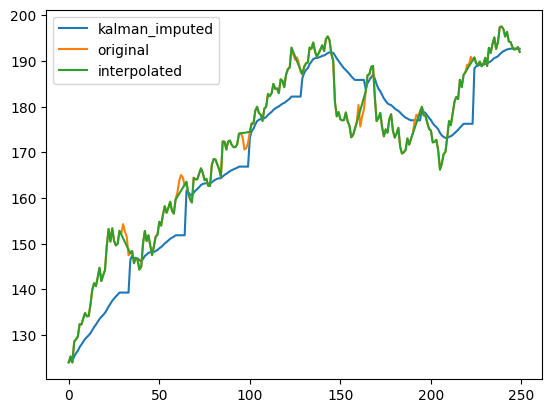

In [11]:
dataseries.plot()

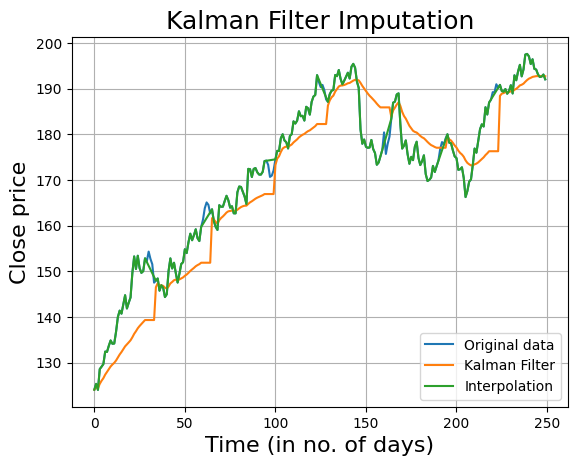

In [12]:
import matplotlib.pyplot as plt
y_1 = dataseries["original"]
y_2 = dataseries["kalman_imputed"]
y_3 = dataseries["interpolated"]
x = dataseries.index
_ = plt.plot(x, y_1)
_ = plt.plot(x, y_2)
_ = plt.plot(x, y_3)

plt.title('Kalman Filter Imputation', fontsize=18)
plt.ylabel("Close price", fontsize=16)
plt.xlabel("Time (in no. of days)", fontsize=16)
plt.legend(('Original data', 'Kalman Filter', 'Interpolation'), loc='lower right')
plt.grid()

# plt.savefig("KalmanFilter")

plt.show()

## Comparing MSE with linear interpolation

In [18]:
print("Kalman Filter", mean_squared_error(imputed_data_series[data.isna()], df[data.isna()].Close))
print("Linear Interpolation", mean_squared_error(data.interpolate(method="linear")[data.isna()], df[data.isna()].Close))

Kalman Filter 89.61845425899325
Linear Interpolation 3.4755440464642504
